In [1]:
import nidaqmx
from nidaqmx.constants import AcquisitionType, Edge, READ_ALL_AVAILABLE
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt

# Confocal

In [2]:
resolution = 200
scan_rate = 100
max_resolution = 500
max_scan_rate = 1000
v_range = 0.3

### SamleClock

In [3]:
clock_task = nidaqmx.Task()
clock_task.co_channels.add_co_pulse_chan_freq(counter='/PXI-6363/ctr1', freq=2*scan_rate, duty_cycle=0.5)  # 2*scan_rate
clock_task.timing.cfg_implicit_timing(sample_mode=AcquisitionType.CONTINUOUS)

In [ ]:
# clock_task.start()

In [ ]:
# clock_task.stop()
# clock_task.close()

### x_task and y_task

In [4]:
x_task = nidaqmx.Task()
y_task = nidaqmx.Task()

x_task.ao_channels.add_ao_voltage_chan('/PXI-6363/ao0')
y_task.ao_channels.add_ao_voltage_chan('/PXI-6363/ao1')

x_task.timing.cfg_samp_clk_timing(
    source='/PXI-6363/Ctr1InternalOutput',
    rate=int(max_scan_rate), 
    sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=resolution,
    active_edge=Edge.RISING
)

### count_task

In [5]:
count_task = nidaqmx.Task()

count_task.ci_channels.add_ci_count_edges_chan("/PXI-6363/ctr0")
count_task.timing.cfg_samp_clk_timing(
    rate=int(max_scan_rate),
    source='/PXI-6363/Ctr1InternalOutput',
    sample_mode=AcquisitionType.FINITE,
    samps_per_chan= resolution
)

##### Test of buffer readin

In [ ]:
count_task.start()
clock_task.start()

In [ ]:
aaa = count_task.read(number_of_samples_per_channel=READ_ALL_AVAILABLE)

In [ ]:
len(aaa)

In [ ]:
aaa

In [ ]:
count_task.stop()
clock_task.stop()

### Scan

In [6]:
x_ar = [v_range*(-1+2*i/(resolution-1)) for i in range(resolution)]
y_ar = [v_range*(-1+2*i/(resolution-1)) for i in range(resolution)]

In [11]:
count_ar = []
raw_count_ar = []

x_task.write(x_ar)

for i in range(resolution):
    y_task.write(y_ar[i])
    y_task.wait_until_done()
    
    x_task.start()
    count_task.start()
    clock_task.start()
    
    x_task.wait_until_done()
    count_task.wait_until_done()
    
    raw_count_line = count_task.read(number_of_samples_per_channel=READ_ALL_AVAILABLE)
    
    x_task.stop()
    count_task.stop()
    clock_task.stop()
    
    raw_count_ar.append(raw_count_line)
    
    count_line = []
    for j in range(resolution):
        if j==0:
            pass
            # count_line.append(raw_count_line[j] * scan_rate)
        else:
            count_line.append( (raw_count_line[j] - raw_count_line[j-1]) * scan_rate)
    count_ar.append(count_line)

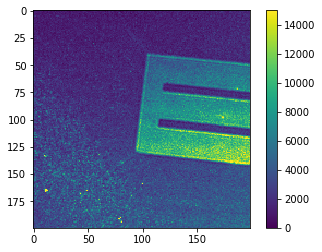

In [12]:
plt.imshow(count_ar, vmin=0, vmax=15e3)
plt.colorbar()
plt.show()

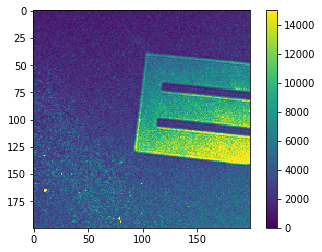

In [10]:
plt.imshow(count_ar, vmin=0, vmax=15e3)
plt.colorbar()
plt.show()

In [17]:
clock_task.stop()
clock_task.close()

x_task.stop()
y_task.stop()
x_task.close()
y_task.close()

count_task.stop()
count_task.close()